<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20891 entries, 0 to 20890
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 20891 non-null  int64  
 1   MONTH                20891 non-null  int64  
 2   DAY                  20891 non-null  int64  
 3   DAY_OF_WEEK          20891 non-null  int64  
 4   AIRLINE              20891 non-null  object 
 5   FLIGHT_NUMBER        20891 non-null  int64  
 6   TAIL_NUMBER          20866 non-null  object 
 7   ORIGIN_AIRPORT       20891 non-null  object 
 8   DESTINATION_AIRPORT  20891 non-null  object 
 9   SCHEDULED_DEPARTURE  20891 non-null  int64  
 10  DEPARTURE_TIME       20323 non-null  float64
 11  DEPARTURE_DELAY      20323 non-null  float64
 12  TAXI_OUT             20318 non-null  float64
 13  WHEELS_OFF           20318 non-null  float64
 14  SCHEDULED_TIME       20891 non-null  int64  
 15  ELAPSED_TIME         20285 non-null 

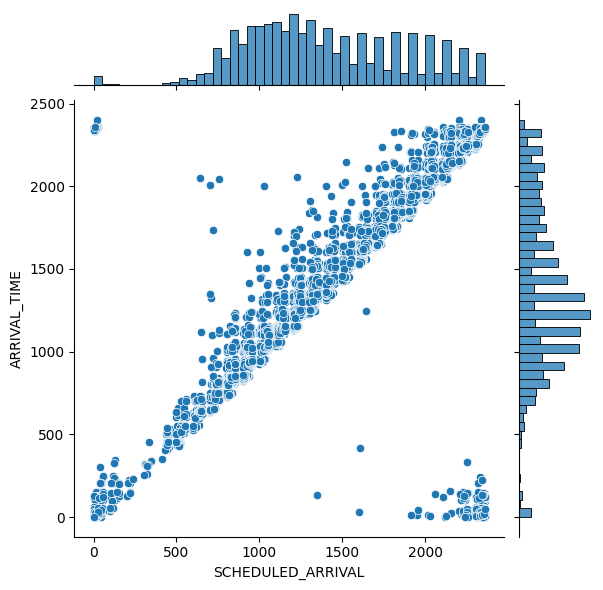

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold
class DataLoader:
    def __init__(self, filepath):
        self.filepath = filepath

    def load_data(self):
        self.data = pd.read_csv(self.filepath, low_memory=False)
        self.data = self.data[0:100000]
        return self.data

class DataExplorer:
    def __init__(self, data):
        self.data = data

    def explore_data(self):
        self.data.info()
        print(self.data.value_counts('DIVERTED'))

    def plot_data(self):
        sns.jointplot(data=self.data, x="SCHEDULED_ARRIVAL", y="ARRIVAL_TIME")

class DataPreprocessor:
    def __init__(self, data):
        self.data = data

    def handle_missing_values(self):
        # Fill missing values for numerical features with mean
        num_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
        for col in num_cols:
            self.data[col].fillna(self.data[col].mean(), inplace=True)

        # Fill missing values for categorical features with mode
        cat_cols = self.data.select_dtypes(include=['object']).columns
        for col in cat_cols:
            self.data[col].fillna(self.data[col].mode()[0], inplace=True)

        return self.data

    def preprocess_data(self):

        # Handling missing values
        self.data = self.handle_missing_values()

        # Convert categorical variables using one-hot encoding
        categorical_cols = self.data.select_dtypes(include=['object']).columns
        self.data = pd.get_dummies(self.data, columns=categorical_cols)

        return self.data


class FeatureEngineer:
    def __init__(self, data):
        self.data = data

    def create_features(self):
        self.data['Delay_Result'] = self.data['ARRIVAL_DELAY'].apply(lambda x: 1 if x > 15 else 0)
        return self.data

    def select_features(self):
        # Select features using variance thresholding
        threshold = 0.01
        selector = VarianceThreshold(threshold)
        self.data = self.data.drop('Delay_Result', axis=1)
        self.data = pd.DataFrame(selector.fit_transform(self.data), columns=self.data.columns[selector.get_support()])
        return self.data

class ModelTrainer:
    def __init__(self, data):
        self.data = data

    def train_model(self):
        feature_columns = [col for col in self.data.columns if col != 'Delay_Result']
        X = self.data[feature_columns].values
        y = self.data['Delay_Result'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        classifier = DecisionTreeClassifier()
        classifier.fit(X_train_scaled, y_train)
        return classifier, X_test_scaled, y_test

class ModelEvaluator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate_model(self):
        predictions = self.model.predict_proba(self.X_test)
        auc_score = roc_auc_score(self.y_test, predictions[:, 1])
        print(f"AUC Score: {auc_score}")

data_loader = DataLoader('/content/flights.csv')
data = data_loader.load_data()

data_explorer = DataExplorer(data)
data_explorer.explore_data()
data_explorer.plot_data()

data_preprocessor = DataPreprocessor(data)
processed_data = data_preprocessor.preprocess_data()

feature_engineer = FeatureEngineer(processed_data)
featured_data = feature_engineer.create_features()
selected_data = feature_engineer.select_features()

selected_data['Delay_Result'] = featured_data['Delay_Result']

model_trainer = ModelTrainer(selected_data)
classifier, X_test, y_test = model_trainer.train_model()

model_evaluator = ModelEvaluator(classifier, X_test, y_test)
model_evaluator.evaluate_model()
